In [1]:
%config Completer.use_jedi = False

In [2]:
import pandas as pd
import pickle, os, sys

In [3]:
!aws s3 ls s3://sg-playground-kkoyama-temp/tcrpred/hhyylog/ | grep 20220211_191954

2022-03-16 02:50:05   10820250 20220211_191954_k3_datasettest.pickle
2022-03-16 02:50:07    2804102 20220211_191954_k3_test_hh.pickle
2022-03-16 02:50:08    2804066 20220211_191954_k3_test_yy.pickle
2022-03-16 02:50:08 7868901734 20220211_191954_results_attention_tes.pickle
2022-03-16 02:53:39 6291223148 20220211_191954_results_attention_tra.pickle
2022-03-16 02:53:41 1577678752 20220211_191954_results_attention_val.pickle


# Files

In [4]:
plist = ['s3://sg-playground-kkoyama-temp/tcrpred/hhyylog/20220211_191954_k3_datasettest.pickle',
 's3://sg-playground-kkoyama-temp/tcrpred/hhyylog/20220211_191954_k3_test_hh.pickle',
 's3://sg-playground-kkoyama-temp/tcrpred/hhyylog/20220211_191954_k3_test_yy.pickle']

In [5]:
!aws s3 ls s3://sg-playground-kkoyama-temp/tcrpred/hhyylog/ | grep 20220211 | grep datasettest

2022-03-16 02:46:31   10820250 20220211_191950_k1_datasettest.pickle
2022-03-16 02:46:32   10820250 20220211_191950_k2_datasettest.pickle
2022-03-16 02:46:34   10820250 20220211_191951_k0_datasettest.pickle
2022-03-16 02:50:05   10820250 20220211_191954_k3_datasettest.pickle
2022-03-16 02:55:30   10820250 20220211_192004_k4_datasettest.pickle


In [7]:
import sys
sys.path.append('../recipes/')
sys.path.append('../scripts/')
from dataset import MCPASDataset
from dataset_selector import dataset_select


In [8]:
KFOLDNUM = 3

# ret = dataset_select('all',kfold=3)

df_all,  dataset_train, dataset_valid, dataset_test, n_tok, n_pos1, n_pos2, n_seg = \
    dataset_select('all', kfold=KFOLDNUM)


../recipes/dataset.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sign'] = df['sign'].astype(int)


datasize and y-vcounts:  (140082, 11) 0    116757
1     23325
Name: sign, dtype: int64
datasize and y-vcounts:  (35129, 11) 0    29331
1     5798
Name: sign, dtype: int64
datasize and y-vcounts:  (175211, 11) 0    146088
1     29123
Name: sign, dtype: int64


In [9]:
len(dataset_train), len(dataset_valid), len(dataset_test)

(140082, 35129, 175211)

In [10]:
p_list = [
    "../external_data/ERGO-II/Samples/vdjdb_train_samples.pickle",
    "../external_data/ERGO-II/Samples/mcpas_train_samples.pickle",
    "../external_data/ERGO-II/Samples/vdjdb_test_samples.pickle",
    "../external_data/ERGO-II/Samples/mcpas_test_samples.pickle",
]

def get_df(datapath):
    return pd.DataFrame(pickle.load(open(datapath, "rb")))

def get_df_from_path(p_list):
    return pd.concat([get_df(d) for d in p_list]).reset_index(drop=True)

df_all = get_df_from_path(p_list)

In [11]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=2)

train_index, valid_index = [
    (train_index, valid_index) for train_index, valid_index in kf.split(df_all)
][KFOLDNUM]

In [12]:
df_train, df_valid = df_all.loc[train_index], df_all.loc[valid_index]

In [13]:
df_train = df_train.query('tcra!="UNK"')
df_valid = df_valid.query('tcra!="UNK"')

In [14]:
df_valid.shape

(35129, 11)

# hhyy analysis

In [15]:
from scipy.special import softmax
from utils import get_infer_report, get_metrics

In [16]:
d20220211_191954_k3_test_hh = pd.read_pickle(plist[1]).apply(softmax, axis=1)
d20220211_191954_k3_test_yy = pd.read_pickle(plist[2])

In [17]:
isin_valid_index = dataset_test.data.apply(tuple,axis=1).isin(dataset_valid.data.apply(tuple,axis=1))
isin_valid_df = dataset_test.data.loc[isin_valid_index]
isin_valid_df.shape

(50379, 11)

In [18]:
isin_train_index = dataset_test.data.apply(tuple,axis=1).isin(dataset_train.data.apply(tuple,axis=1))
isin_train_df = dataset_test.data.loc[isin_train_index]
isin_train_df.shape

(149674, 11)

## Validation set

- acc 0.6756585085055281
- balanced_acc 0.7211840521829265
- precision on 1:  0.2547443068318018
- precision on 0:  0.9533190578158458
- confusion matrix tn, fp, fn, tp: 28938, 14923, 1417, 5101
- roc_auc_score 0.8175009851304436
- pr_auc_score on 1 0.46215746084731496
- pr_auc_score on 0 0.9666643011993737


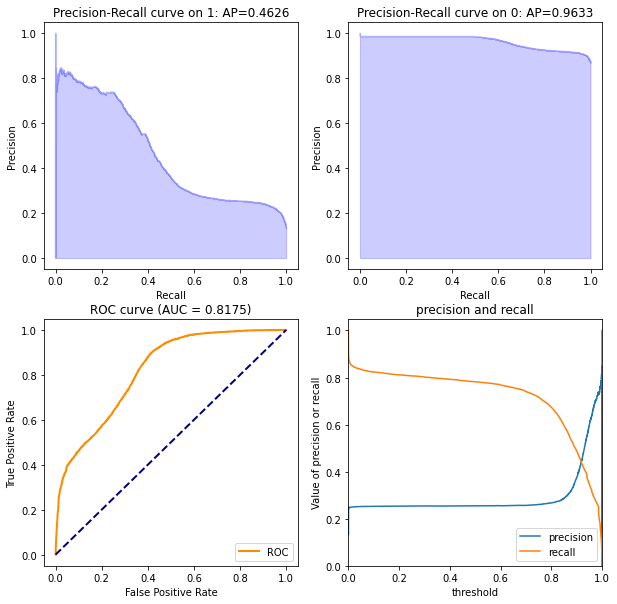

In [19]:
ypred = d20220211_191954_k3_test_hh.iloc[isin_valid_df.index][1]
ytrue = d20220211_191954_k3_test_yy.iloc[isin_valid_df.index].values
get_infer_report(ytrue, ypred)

## Training set

- acc 0.7980744818739394
- balanced_acc 0.8799166742629394
- precision on 1:  0.438993593909572
- precision on 0:  0.9998956365647732
- confusion matrix tn, fp, fn, tp: 95809, 30213, 10, 23642
- roc_auc_score 0.9500170737317377
- pr_auc_score on 1 0.7837038633464529
- pr_auc_score on 0 0.9906427507737353


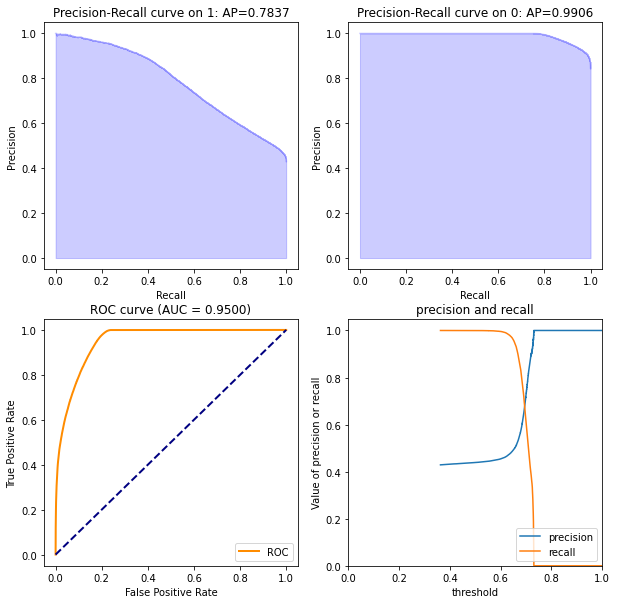

In [20]:
ypred = d20220211_191954_k3_test_hh.iloc[isin_train_df.index].apply(softmax, axis=1)[1]
ytrue = d20220211_191954_k3_test_yy.iloc[isin_train_df.index].values
get_infer_report(ytrue, ypred)

# PDB

In [22]:
directory = "../analysis/DICT_PDB_Result"
!ls {directory}

2021_DICT_PDBID_2_Atten12.pickle
2021_DICT_PDBID_2_CDRS.pickle
2021_DICT_PDBID_2_CHAINNAMES.pickle
2021_DICT_PDBID_2_DISTANCE.pickle
2021_DICT_PDBID_2_MELTDIST.pickle
2021_DICT_PDBID_2_RESIDUES.pickle
2021_DICT_PDBID_2_SEQUENCES_CDR.pickle
2021_DICT_PDBID_2_dfhhb.pickle
2021_DICT_PDBID_2_dfnnb.pickle
2021_DICT_PDBID_2_model_out.pickle
20220211_191954_DICT_PDBID_2_Atten12.pickle
20220211_191954_DICT_PDBID_2_CDRS.pickle
20220211_191954_DICT_PDBID_2_CHAINNAMES.pickle
20220211_191954_DICT_PDBID_2_DISTANCE.pickle
20220211_191954_DICT_PDBID_2_MELTDIST.pickle
20220211_191954_DICT_PDBID_2_RESIDUES.pickle
20220211_191954_DICT_PDBID_2_SEQUENCES_CDR.pickle
20220211_191954_DICT_PDBID_2_dfhhb.pickle
20220211_191954_DICT_PDBID_2_model_out.pickle


In [27]:
pickleload = lambda p: pickle.load(open(p,"rb"))
DICT_PDBID_2_SEQUENCES_CDR = pickleload(f"{directory}/20220211_191954_DICT_PDBID_2_SEQUENCES_CDR.pickle")

In [28]:
df_DICT_PDBID_2_SEQUENCES_CDR = pd.DataFrame(DICT_PDBID_2_SEQUENCES_CDR).T
df_DICT_PDBID_2_SEQUENCES_CDR.columns = ['tcra','tcrb','peptide']
df_DICT_PDBID_2_SEQUENCES_CDR.drop_duplicates(subset=['tcra','tcrb','peptide'], inplace=True)
df_DICT_PDBID_2_SEQUENCES_CDR.shape

(49, 3)

In [29]:
df_DICT_PDBID_2_SEQUENCES_CDR.head(2)

,tcra,tcrb,peptide
2VLK,CAGAGSQGNLIF,CASSSRSSYEQYF,GILGFVFTL
2ICW,CAVSGFASALTF,CASGGGGTLYF,PKYVKQNTLKLAT


In [74]:
dfall = get_df_from_path(p_list)
merged_df = pd.merge(dfall,  
                     df_DICT_PDBID_2_SEQUENCES_CDR.reset_index(),  
                     on=['tcra','tcrb','peptide'],
                     how='inner')

In [81]:
merged_df = merged_df.rename(columns={'index':'pdbid'})
merged_df.shape

(73, 12)

In [82]:
DICT_PDBID_2_model_out = pickleload(f'{directory}/20220211_191954_DICT_PDBID_2_model_out.pickle')

In [88]:
merged_df['in_pdb'] = merged_df['pdbid'].isin(DICT_PDBID_2_model_out.keys()) #.drop_duplicates(subset=['tcra','tcrb','peptide'])

In [91]:
merged_df['pdbid'].nunique()

30

In [92]:
len(DICT_PDBID_2_model_out)

55

In [93]:
pd.Series(DICT_PDBID_2_model_out.keys()).isin(merged_df.pdbid)

0      True
1     False
2      True
3     False
4      True
5      True
6      True
7      True
8     False
9     False
10     True
11     True
12    False
13     True
14     True
15     True
16     True
17     True
18    False
19     True
20    False
21     True
22     True
23    False
24    False
25     True
26     True
27     True
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35     True
36    False
37     True
38     True
39    False
40    False
41    False
42     True
43     True
44     True
45    False
46    False
47     True
48     True
49    False
50     True
51     True
52    False
53     True
54    False
dtype: bool

In [100]:
for k in DICT_PDBID_2_model_out.keys():
    if k in merged_df.pdbid.tolist():
        print("    in", k, f'{DICT_PDBID_2_model_out[k][2]:.5f}')
    else:
        print("not in", k, f'{DICT_PDBID_2_model_out[k][2]:.5f}')

    in 2VLK 0.89269
not in 2ICW 0.00000
    in 5WKF 0.99989
not in 2VLJ 0.89269
    in 3PQY 0.99885
    in 4MJI 0.99678
    in 4P2Q 0.99391
    in 2YPL 0.99995
not in 5BRZ 0.00001
not in 6RPB 0.02039
    in 1J8H 0.99992
    in 4P2R 0.99996
not in 5MEN 0.98003
    in 3MV8 0.99999
    in 4OZF 0.98565
    in 3VXR 0.99581
    in 3VXS 0.98201
    in 4OZG 0.99433
not in 3MV9 0.99999
    in 5TEZ 0.96738
not in 2J8U 0.99946
    in 6Q3S 0.99993
    in 4JRX 0.99988
not in 5WLG 0.00000
not in 3VXU 0.99808
    in 1U3H 0.99955
    in 4JRY 0.99962
    in 4Z7V 0.98460
not in 2UWE 0.99946
not in 1LP9 0.99946
not in 3W0W 0.99808
not in 6AVF 0.08695
not in 2BNQ 0.99993
not in 4JFE 0.99997
not in 4JFD 0.99997
    in 3QIU 0.99055
not in 6AVG 0.00018
    in 2Z31 0.99913
    in 2BNR 0.99990
not in 5ISZ 0.15928
not in 5KS9 0.00000
not in 3MV7 0.99999
    in 3MBE 0.99915
    in 4OZH 0.98000
    in 2NX5 0.99816
not in 5NHT 0.99960
not in 4QOK 0.99813
    in 5D2L 0.99572
    in 1D9K 0.99978
not in 1FYT 0.99992
